# 5. Covid-19 samples from healthy, mild and severe patients
Chen ST, Park MD, Del Valle DM, Buckup M, Tabachnikova A, Thompson RC, et al. A shift in lung macrophage composition is associated with COVID-19 severity and recovery. Sci Transl Med. 2022;14:eabn5168

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.get_transformed_props import get_transformed_props

In [2]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [3]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [4]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

------------------

## Read data

In [5]:
covid_counts = pd.read_csv("data/covid_counts.tsv", sep='\t')
covid = convert_counts_to_df(covid_counts, column_name="celltype")

In [6]:
covid

,sample,sample_new,group,disease,hasnCoV,celltype
cell_1,C100,HC3,HC,N,N,B
cell_2,C100,HC3,HC,N,N,B
cell_3,C100,HC3,HC,N,N,B
cell_4,C100,HC3,HC,N,N,B
cell_5,C100,HC3,HC,N,N,B
...,...,...,...,...,...,...
cell_65809,C52,HC2,HC,N,N,pDC
cell_65810,GSM3660650,HC4,HC,N,N,pDC
cell_65811,GSM3660650,HC4,HC,N,N,pDC
cell_65812,GSM3660650,HC4,HC,N,N,pDC


----------

## Run Scanpro

### Logit

In [7]:
out_covid_logit = scanpro.scanpro(covid, clusters_col='celltype', 
                                          conds_col='group', samples_col='sample_new')
out_covid_logit.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,f_statistics,p_values,adjusted_p_values
celltype,,,,,,,
B,0.003343,0.003503,0.012990,0.004005,2.593405,0.074765,0.106807
Epithelial,0.053652,0.130246,0.051903,0.118455,1.536041,0.215232,0.249978
Macrophages,0.750870,0.735290,0.512996,0.604316,1.491742,0.224980,0.249978
Mast,0.001064,0.002337,0.002220,0.001699,1.164873,0.311962,0.311962
NK,0.016425,0.008894,0.052466,0.017979,4.841923,0.007892,0.026306
Neutrophil,0.024418,0.000000,0.001204,0.055594,92.441438,0.000000,0.000000
Plasma,0.015818,0.000224,0.002150,0.050913,10.404122,0.000030,0.000152
T,0.117241,0.094594,0.325030,0.137097,3.081910,0.045872,0.084251
mDC,0.014860,0.023776,0.030831,0.008876,2.984785,0.050550,0.084251


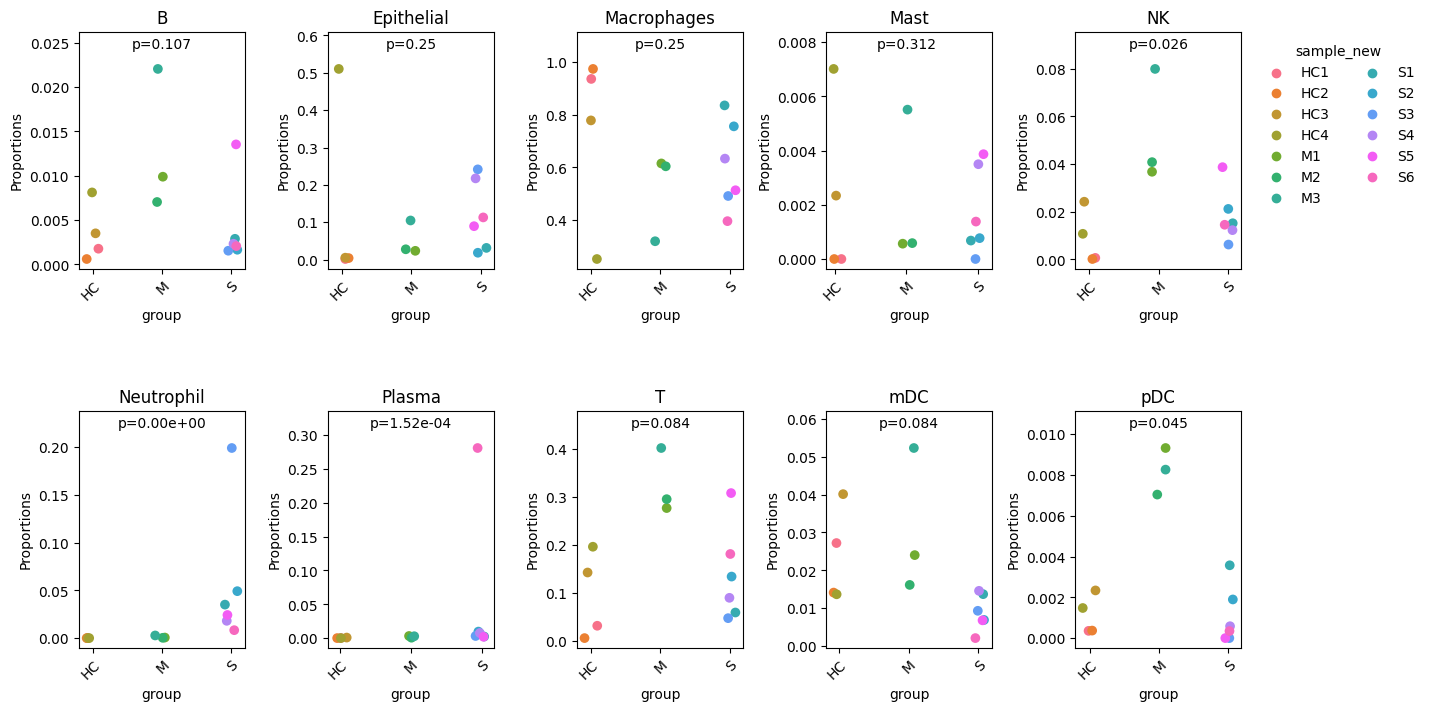

In [8]:
out_covid_logit.plot(n_columns=5, save=f"{FIG_PATH}/covid19_boxplot.pdf")

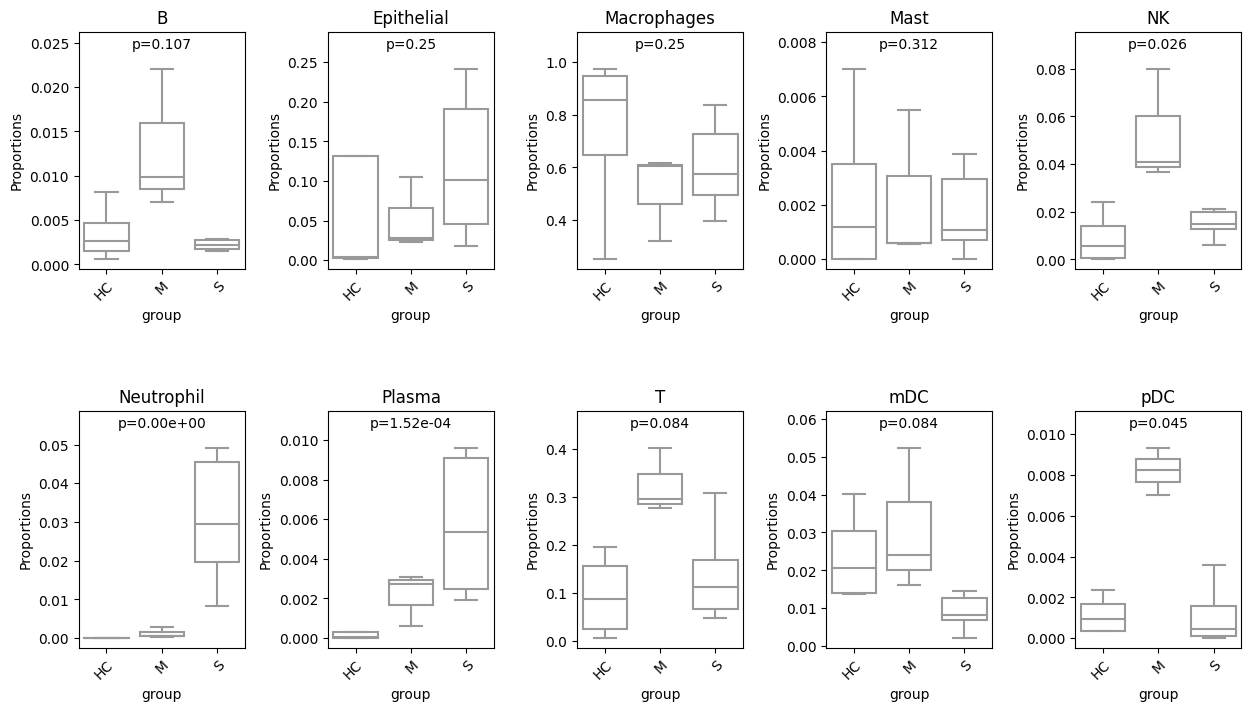

In [9]:
out_covid_logit.plot(kind='boxplot', n_columns=5, save=f"{FIG_PATH}/covid19_boxplot.pdf")

In [10]:
out_covid_logit.results.to_csv("results/covid_scanpro_rep_logit.tsv", sep="\t")

### arcsin

In [11]:
out_covid_arcsin = scanpro.scanpro(covid, clusters_col='celltype', samples_col='sample_new',
                                   conds_col='group', transform='arcsin')
out_covid_arcsin.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,f_statistics,p_values,adjusted_p_values
celltype,,,,,,,
B,0.003343,0.003503,0.012990,0.004005,3.200032,0.040761,0.067935
Epithelial,0.053652,0.130246,0.051903,0.118455,0.310040,0.733418,0.814908
Macrophages,0.750870,0.735290,0.512996,0.604316,1.237913,0.289989,0.362486
Mast,0.001064,0.002337,0.002220,0.001699,0.042212,0.958667,0.958667
NK,0.016425,0.008894,0.052466,0.017979,7.534890,0.000534,0.001780
Neutrophil,0.024418,0.000000,0.001204,0.055594,7.709304,0.000449,0.001780
Plasma,0.015818,0.000224,0.002150,0.050913,1.387393,0.249726,0.356751
T,0.117241,0.094594,0.325030,0.137097,5.454035,0.004279,0.010698
mDC,0.014860,0.023776,0.030831,0.008876,5.055541,0.006374,0.012748


In [12]:
out_covid_arcsin.results.to_csv("results/covid_scanpro_rep_arcsin.tsv", sep="\t")

----------

## Without replicates

### Logit

In [13]:
out_covid_boot_logit = scanpro.scanpro(covid, clusters_col='celltype',
                                       conds_col='group', n_reps=8)

out_covid_boot_logit.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 17.35 seconds


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,p_values
celltype,,,,,
B,0.003343,0.001372,0.007502,0.001958,1.349471e-01
Epithelial,0.053652,0.061720,0.026265,0.045819,2.991314e-01
Macrophages,0.750870,0.850207,0.599225,0.727359,2.411694e-02
Mast,0.001064,0.000523,0.000415,0.000592,4.832450e-01
NK,0.016425,0.003145,0.036964,0.015301,7.049451e-03
Neutrophil,0.024418,0.000000,0.000249,0.038975,2.567539e-09
Plasma,0.015818,0.000034,0.001086,0.023123,3.773859e-06
T,0.117241,0.051069,0.285230,0.118617,3.177709e-03
mDC,0.014860,0.019081,0.019148,0.007420,2.816998e-01


In [14]:
out_covid_boot_logit.results.to_csv("results/covid_scanpro_norep_logit.tsv", sep="\t")

### Arcsin

In [15]:
out_covid_boot_arcsin = scanpro.scanpro(covid, clusters_col='celltype',
                                       conds_col='group', n_reps=8, transform='arcsin')

out_covid_boot_arcsin.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 17.41 seconds


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,p_values
celltype,,,,,
B,0.003343,0.001400,0.007493,0.001976,9.790488e-02
Epithelial,0.053652,0.061655,0.026211,0.045517,1.240456e-01
Macrophages,0.750870,0.850725,0.598391,0.726995,7.176954e-05
Mast,0.001064,0.000519,0.000413,0.000593,6.535668e-01
NK,0.016425,0.003127,0.036653,0.015235,6.636199e-04
Neutrophil,0.024418,0.000000,0.000249,0.038993,1.778270e-09
Plasma,0.015818,0.000035,0.001070,0.023040,2.119768e-06
T,0.117241,0.051025,0.286811,0.118593,3.486753e-07
mDC,0.014860,0.019017,0.019148,0.007329,1.731609e-01


In [16]:
out_covid_boot_arcsin.results.to_csv("results/covid_scanpro_norep_arcsin.tsv", sep="\t")

-----------------

#### Plasma cells have one sample as outlier, which affects the bootstrapping result

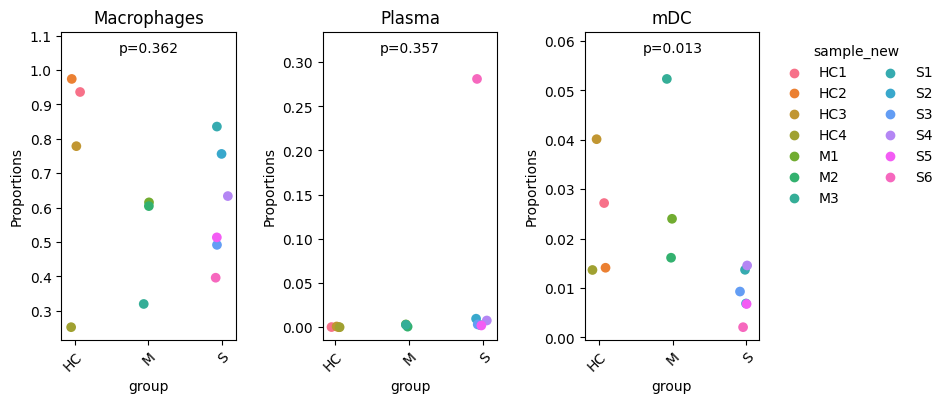

In [21]:
out_covid_arcsin.plot(n_columns=5, clusters=['Macrophages', 'Plasma', 'mDC'],
                      save=f'{FIG_PATH}/covid_stripplot_example.pdf')

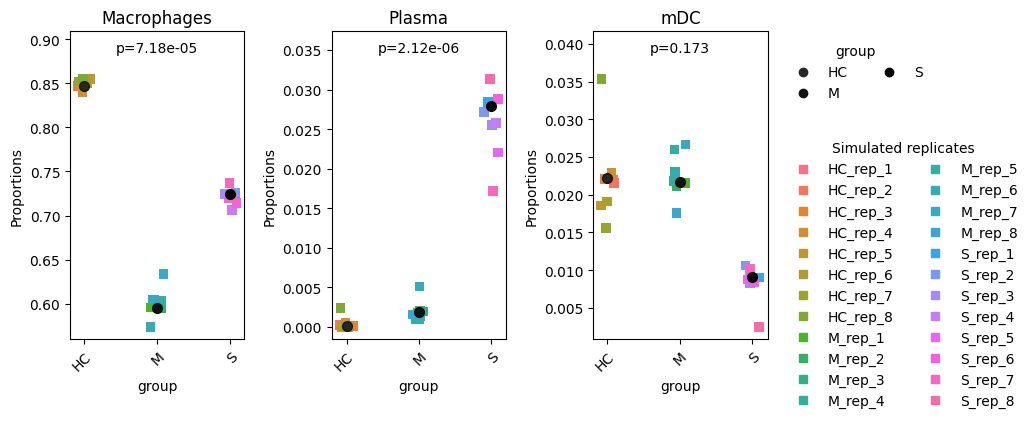

In [22]:
out_covid_boot_arcsin.plot(clusters=['Macrophages', 'Plasma', 'mDC'],
                           save=f'{FIG_PATH}/covid_stripplot_norep_example.pdf')